In [1]:
import pickle
import pandas as pd
import numpy as np

import gensim
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.ldamodel import LdaModel
from gensim.corpora import Dictionary
from nltk.corpus import stopwords
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.cluster import KMeans

import pyLDAvis
import pyLDAvis.gensim
import seaborn as sns
import datetime as datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import calendar
%matplotlib inline

//anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_extraction.stop_words module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_extraction.text. Anything that cannot be imported from sklearn.feature_extraction.text is now part of the private API.
  warnings.warn(message, FutureWarning)


In [154]:
df = pd.read_pickle("./preprocessed.pkl")

In [16]:
df.sort_values('date')

,text,tokenized,articles,date
66,"Audio Network has appointed Todd King as VP, W...",audio network appointed todd king west coast k...,audio network appoint todd king west coast kin...,2018-11-01
65,Big Deal Music Publishing Group has signed a d...,big deal publishing group signed deal represen...,big deal music publishing group sign deal repr...,2018-11-01
64,"YouTube’s Global Head of Music, Lyor Cohen has...",youtube global head lyor cohen called implicat...,youtube global head music lyor cohen call impl...,2018-11-01
63,Global has acquired the digital audio sales di...,global acquired digital audio sales division c...,global acquire digital audio sale division can...,2018-11-01
62,"In six months’ time, the fun and games begin a...",six months time fun games begin anew understan...,six month time fun game begin anew mbw underst...,2018-11-01
...,...,...,...,...
4,Warner Music Group’s IPO was supposed to start...,warner group ipo supposed start kicking week c...,warner music group ipo suppose start kick week...,2020-03-02
3,Amuse has fast become one of the most recogniz...,amuse fast become one recognizable names indep...,amuse fast become one recognizable name indepe...,2020-03-02
2,Independent record company Glassnote has hired...,independent record company glassnote hired dex...,independent record company glassnote hire dext...,2020-03-03
0,When Ralph Simon was a child in Johannesburg i...,ralph simon child johannesburg mother gave adv...,ralph simon child johannesburg mother give adv...,2020-03-03


### create new df 

In [155]:
data = df['date']

In [156]:
count_df = pd.DataFrame(data, columns = ['date'])

In [141]:
count_df.head(10)

,date
0,2020-02-28
1,2020-02-22
2,2020-02-19
3,2020-01-24
4,2019-12-12
5,2019-11-18
6,2019-11-10
7,2019-10-31
8,2019-10-25
9,2019-09-23


In [157]:
count_df['articles'] = df['tokenized']

### create year and month columns

In [158]:
ser1 = pd.Series(count_df['date']) 
#new = count_df['date'].str.split("-" , n=1, expand = True)
#count_df['year']= new [0]
#count_df['month']= new[1]

count_df['new_date'] = pd.to_datetime(count_df['date']).apply(lambda x:x.strftime('%Y-%m')) # Convert to DateTime and group by month 

In [159]:
count_df.head()

,date,articles,new_date
0,2020-02-28,recent rainy night manhattan kelsea ballerini ...,2020-02
1,2020-02-22,forget minute two men thought sang milli vanil...,2020-02
2,2020-02-19,editors note ongoing series explore best buzzw...,2020-02
3,2020-01-24,continues grow change decided time annual powe...,2020-01
4,2019-12-12,desiree perez coo roc nation typical day desir...,2019-12


### bag of words

In [94]:
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import numpy as np
np.random.seed(2018)
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /Users/linan_c/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [102]:
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(token)
    return result

In [103]:
text = df['tokenized'].map(preprocess)
text[:10]

0    [recent, rainy, night, manhattan, kelsea, ball...
1    [forget, minute, thought, sang, milli, vanilli...
2    [editors, note, ongoing, series, explore, best...
3    [continues, grow, change, decided, time, annua...
4    [desiree, perez, nation, typical, desiree, per...
5    [digital, data, today, drives, aspect, billion...
6    [august, onerepublic, took, stage, rocks, amph...
7    [hootie, blowfish, like, thing, clear, broke, ...
8    [kanye, west, starts, conversations, debates, ...
9    [known, oscars, advertising, clio, awards, sal...
Name: tokenized, dtype: object

In [104]:
dictionary = gensim.corpora.Dictionary(text)

In [105]:
count = 0
for k, v in dictionary.iteritems():
    print(k, v)
    count += 1
    if count > 10:
        break

0 able
1 absorb
2 acceptable
3 active
4 activity
5 acts
6 adding
7 admits
8 advice
9 afraid
10 airplay


In [106]:
#filtering out words that appear in less than 15 docs or more than 0.5% of docs
#keep only the 100000 most frequent words
dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)

### Gensim doc2bow

In [110]:
bow_corpus = [dictionary.doc2bow(doc) for doc in text]
bow_corpus[2000]

[(0, 4),
 (8, 8),
 (17, 1),
 (21, 1),
 (22, 2),
 (23, 2),
 (27, 6),
 (29, 1),
 (34, 3),
 (37, 1),
 (40, 3),
 (45, 3),
 (47, 1),
 (50, 1),
 (55, 1),
 (56, 1),
 (58, 1),
 (60, 1),
 (67, 12),
 (68, 1),
 (70, 1),
 (72, 2),
 (74, 1),
 (79, 1),
 (80, 2),
 (83, 1),
 (84, 1),
 (86, 1),
 (87, 1),
 (89, 2),
 (90, 2),
 (95, 5),
 (96, 1),
 (101, 2),
 (109, 2),
 (113, 4),
 (114, 1),
 (118, 1),
 (119, 2),
 (121, 2),
 (125, 1),
 (137, 1),
 (142, 3),
 (143, 1),
 (144, 4),
 (145, 1),
 (146, 3),
 (151, 1),
 (154, 1),
 (155, 9),
 (158, 3),
 (161, 2),
 (162, 3),
 (169, 3),
 (171, 3),
 (177, 2),
 (185, 1),
 (186, 5),
 (191, 1),
 (196, 2),
 (200, 1),
 (201, 1),
 (202, 1),
 (203, 1),
 (216, 19),
 (217, 1),
 (218, 2),
 (219, 1),
 (223, 4),
 (228, 1),
 (229, 1),
 (231, 1),
 (233, 1),
 (235, 1),
 (237, 1),
 (240, 1),
 (241, 1),
 (245, 2),
 (250, 2),
 (252, 1),
 (269, 2),
 (270, 6),
 (271, 1),
 (275, 1),
 (279, 1),
 (280, 4),
 (281, 1),
 (285, 7),
 (293, 1),
 (295, 4),
 (298, 1),
 (302, 5),
 (307, 5),
 (308, 2),

In [111]:
#preview bag of words for the processed doc
bow_doc_2000 = bow_corpus[2000]
for i in range(len(bow_doc_2000)):
    print("Word {} (\"{}\") appears {} time.".format(bow_doc_2000[i][0], 
                                               dictionary[bow_doc_2000[i][0]], 
bow_doc_2000[i][1]))

Word 0 ("able") appears 4 time.
Word 8 ("album") appears 8 time.
Word 17 ("artwork") appears 1 time.
Word 21 ("basis") appears 1 time.
Word 22 ("best") appears 2 time.
Word 23 ("biggest") appears 2 time.
Word 27 ("brand") appears 6 time.
Word 29 ("brothers") appears 1 time.
Word 34 ("career") appears 3 time.
Word 37 ("challenge") appears 1 time.
Word 40 ("chart") appears 3 time.
Word 45 ("club") appears 3 time.
Word 47 ("comes") appears 1 time.
Word 50 ("completely") appears 1 time.
Word 55 ("content") appears 1 time.
Word 56 ("cool") appears 1 time.
Word 58 ("country") appears 1 time.
Word 60 ("course") appears 1 time.
Word 67 ("dance") appears 12 time.
Word 68 ("debuted") appears 1 time.
Word 70 ("design") appears 1 time.
Word 72 ("digital") appears 2 time.
Word 74 ("direct") appears 1 time.
Word 79 ("encouraging") appears 1 time.
Word 80 ("ended") appears 2 time.
Word 83 ("entertainment") appears 1 time.
Word 84 ("especially") appears 1 time.
Word 86 ("excited") appears 1 time.
Word

### TF-IDF

In [112]:
from gensim import corpora, models

In [113]:
tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]

In [114]:
from pprint import pprint

In [115]:
for doc in corpus_tfidf:
    pprint(doc)
    break

[(0, 0.01108437516391214),
 (1, 0.015935399016891984),
 (2, 0.021644347826587897),
 (3, 0.014478156689721093),
 (4, 0.018903028589272054),
 (5, 0.02494227560844401),
 (6, 0.02804023326711463),
 (7, 0.025707501943120232),
 (8, 0.04043523800560484),
 (9, 0.028279646137885556),
 (10, 0.013068146350983535),
 (11, 0.013409899797971251),
 (12, 0.03825922593203684),
 (13, 0.030974972613473612),
 (14, 0.02139224757532128),
 (15, 0.04207166444683254),
 (16, 0.027371859014219697),
 (17, 0.029057397033655404),
 (18, 0.02479971481945437),
 (19, 0.014478156689721093),
 (20, 0.7942242139538779),
 (21, 0.018118860203695134),
 (22, 0.007879650896607618),
 (23, 0.00991697710057141),
 (24, 0.028279646137885556),
 (25, 0.030269391871908222),
 (26, 0.031359556307475195),
 (27, 0.01204605544778087),
 (28, 0.025237384079587134),
 (29, 0.04436150705120554),
 (30, 0.026393975175862294),
 (31, 0.024005718874772864),
 (32, 0.022370131413678686),
 (33, 0.029057397033655404),
 (34, 0.009287866009162999),
 (35, 0.

## restart here

In [2]:
#adapting code from 
#https://github.com/bensjx/Topic-Over-Time-LDA/blob/master/topic-over-time-lda.ipynb

### generate dictionary & corpus

In [7]:
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(token)
    return result

In [8]:
text = df['tokenized'].map(preprocess)

In [12]:
dic = gensim.corpora.Dictionary(text) # Associate words to a numeric ID
dic.filter_extremes(no_below=0.1*dic.num_docs, no_above=0.9) # Filter out extreme values: token should appear between 10% to 90% of the corpus
corpus = [dic.doc2bow(doc) for doc in text]
print('Number of unique tokens: %d' % len(dic))
print('Number of documents: %d' % len(corpus))

2020-03-10 00:36:58,464 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2020-03-10 00:36:59,867 : INFO : built Dictionary(34240 unique tokens: ['able', 'absorb', 'acceptable', 'active', 'activity']...) from 2244 documents (total 674177 corpus positions)
2020-03-10 00:36:59,980 : INFO : discarding 33908 tokens: [('absorb', 5), ('acceptable', 6), ('active', 182), ('activity', 74), ('adding', 114), ('admits', 9), ('advice', 44), ('afraid', 27), ('airplay', 39), ('alexander', 26)]...
2020-03-10 00:36:59,981 : INFO : keeping 332 tokens which were in no less than 224 and no more than 2019 (=90.0%) documents
2020-03-10 00:37:00,001 : INFO : resulting dictionary: Dictionary(332 unique tokens: ['able', 'acts', 'album', 'alongside', 'america']...)


Number of unique tokens: 332
Number of documents: 2244


### elbow plot to find optimal number of topics

In [176]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        # Figure our hyper parameters using logging
        model=LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics,
                       passes = 100, random_state = 100)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

# Parameters
limit=20; start=2; step=1;

# Warning: This cell takes a long time to run
model_list, coherence_values = compute_coherence_values(dictionary=dic, 
                                                        corpus=corpus, texts=text, 
                                                        start=start, limit=limit, step=step)

# Show graph
x = range(start, limit, step)
plt.plot(x,coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

2020-03-10 04:14:31,957 : INFO : using symmetric alpha at 0.5
2020-03-10 04:14:32,018 : INFO : using symmetric eta at 0.5
2020-03-10 04:14:32,046 : INFO : using serial LDA version on this node
2020-03-10 04:14:32,066 : INFO : running online (multi-pass) LDA training, 2 topics, 100 passes over the supplied corpus of 2244 documents, updating model once every 2000 documents, evaluating perplexity every 2244 documents, iterating 50x with a convergence threshold of 0.001000
2020-03-10 04:14:32,109 : INFO : PROGRESS: pass 0, at document #2000/2244
2020-03-10 04:14:37,336 : INFO : merging changes from 2000 documents into a model of 2244 documents
2020-03-10 04:14:37,348 : INFO : topic #0 (0.500): 0.020*"spotify" + 0.016*"year" + 0.014*"company" + 0.013*"streaming" + 0.013*"like" + 0.013*"artist" + 0.012*"industry" + 0.011*"worldwide" + 0.010*"years" + 0.009*"time"
2020-03-10 04:14:37,350 : INFO : topic #1 (0.500): 0.019*"company" + 0.017*"year" + 0.013*"global" + 0.012*"like" + 0.011*"time" +

2020-03-10 04:15:01,441 : INFO : topic #1 (0.500): 0.022*"company" + 0.017*"group" + 0.016*"team" + 0.015*"global" + 0.014*"worldwide" + 0.014*"digital" + 0.013*"industry" + 0.012*"marketing" + 0.012*"president" + 0.011*"including"
2020-03-10 04:15:01,443 : INFO : topic diff=0.054297, rho=0.374713
2020-03-10 04:15:02,022 : INFO : -5.524 per-word bound, 46.0 perplexity estimate based on a held-out corpus of 244 documents with 26379 words
2020-03-10 04:15:02,025 : INFO : PROGRESS: pass 5, at document #2244/2244
2020-03-10 04:15:02,413 : INFO : merging changes from 244 documents into a model of 2244 documents
2020-03-10 04:15:02,414 : INFO : topic #0 (0.500): 0.024*"spotify" + 0.018*"year" + 0.018*"like" + 0.017*"people" + 0.016*"time" + 0.016*"artist" + 0.013*"streaming" + 0.012*"songs" + 0.012*"album" + 0.012*"company"
2020-03-10 04:15:02,416 : INFO : topic #1 (0.500): 0.021*"company" + 0.018*"group" + 0.016*"team" + 0.015*"global" + 0.015*"worldwide" + 0.014*"digital" + 0.012*"industry

2020-03-10 04:15:22,252 : INFO : topic #1 (0.500): 0.022*"company" + 0.018*"group" + 0.017*"team" + 0.016*"global" + 0.015*"worldwide" + 0.014*"digital" + 0.013*"sony" + 0.012*"marketing" + 0.012*"industry" + 0.012*"president"
2020-03-10 04:15:22,254 : INFO : topic diff=0.038262, rho=0.287219
2020-03-10 04:15:22,257 : INFO : PROGRESS: pass 11, at document #2000/2244
2020-03-10 04:15:24,956 : INFO : merging changes from 2000 documents into a model of 2244 documents
2020-03-10 04:15:24,958 : INFO : topic #0 (0.500): 0.025*"spotify" + 0.020*"year" + 0.020*"like" + 0.017*"people" + 0.017*"time" + 0.016*"artist" + 0.014*"streaming" + 0.012*"album" + 0.012*"songs" + 0.011*"company"
2020-03-10 04:15:24,961 : INFO : topic #1 (0.500): 0.022*"company" + 0.018*"group" + 0.016*"team" + 0.016*"global" + 0.015*"worldwide" + 0.014*"digital" + 0.013*"sony" + 0.013*"industry" + 0.012*"marketing" + 0.012*"president"
2020-03-10 04:15:24,962 : INFO : topic diff=0.036009, rho=0.276058
2020-03-10 04:15:25,5

2020-03-10 04:15:42,560 : INFO : topic #1 (0.500): 0.023*"company" + 0.018*"group" + 0.017*"team" + 0.016*"global" + 0.015*"worldwide" + 0.014*"digital" + 0.013*"sony" + 0.013*"industry" + 0.013*"marketing" + 0.012*"president"
2020-03-10 04:15:42,561 : INFO : topic diff=0.029476, rho=0.234908
2020-03-10 04:15:43,095 : INFO : -5.520 per-word bound, 45.9 perplexity estimate based on a held-out corpus of 244 documents with 26379 words
2020-03-10 04:15:43,096 : INFO : PROGRESS: pass 16, at document #2244/2244
2020-03-10 04:15:43,443 : INFO : merging changes from 244 documents into a model of 2244 documents
2020-03-10 04:15:43,446 : INFO : topic #0 (0.500): 0.025*"spotify" + 0.020*"year" + 0.020*"like" + 0.018*"people" + 0.017*"time" + 0.016*"artist" + 0.014*"streaming" + 0.013*"songs" + 0.012*"album" + 0.011*"record"
2020-03-10 04:15:43,448 : INFO : topic #1 (0.500): 0.022*"company" + 0.018*"group" + 0.017*"team" + 0.016*"global" + 0.015*"worldwide" + 0.014*"digital" + 0.014*"sony" + 0.013

2020-03-10 04:16:01,082 : INFO : topic #1 (0.500): 0.023*"company" + 0.019*"group" + 0.017*"team" + 0.016*"global" + 0.015*"worldwide" + 0.014*"digital" + 0.014*"sony" + 0.013*"marketing" + 0.012*"industry" + 0.012*"president"
2020-03-10 04:16:01,083 : INFO : topic diff=0.026102, rho=0.207964
2020-03-10 04:16:01,085 : INFO : PROGRESS: pass 22, at document #2000/2244
2020-03-10 04:16:03,462 : INFO : merging changes from 2000 documents into a model of 2244 documents
2020-03-10 04:16:03,464 : INFO : topic #0 (0.500): 0.026*"spotify" + 0.021*"year" + 0.020*"like" + 0.018*"people" + 0.017*"time" + 0.016*"artist" + 0.014*"streaming" + 0.012*"album" + 0.012*"songs" + 0.011*"record"
2020-03-10 04:16:03,465 : INFO : topic #1 (0.500): 0.023*"company" + 0.018*"group" + 0.017*"team" + 0.016*"global" + 0.015*"worldwide" + 0.014*"digital" + 0.014*"sony" + 0.013*"industry" + 0.013*"marketing" + 0.012*"president"
2020-03-10 04:16:03,466 : INFO : topic diff=0.024841, rho=0.203607
2020-03-10 04:16:03,98

2020-03-10 04:16:19,945 : INFO : topic #1 (0.500): 0.023*"company" + 0.018*"group" + 0.017*"team" + 0.016*"global" + 0.015*"worldwide" + 0.014*"digital" + 0.014*"sony" + 0.013*"industry" + 0.013*"marketing" + 0.012*"president"
2020-03-10 04:16:19,947 : INFO : topic diff=0.022223, rho=0.185306
2020-03-10 04:16:20,680 : INFO : -5.519 per-word bound, 45.9 perplexity estimate based on a held-out corpus of 244 documents with 26379 words
2020-03-10 04:16:20,681 : INFO : PROGRESS: pass 27, at document #2244/2244
2020-03-10 04:16:21,078 : INFO : merging changes from 244 documents into a model of 2244 documents
2020-03-10 04:16:21,080 : INFO : topic #0 (0.500): 0.025*"spotify" + 0.020*"year" + 0.020*"like" + 0.018*"people" + 0.017*"time" + 0.016*"artist" + 0.014*"streaming" + 0.013*"songs" + 0.013*"album" + 0.011*"record"
2020-03-10 04:16:21,084 : INFO : topic #1 (0.500): 0.023*"company" + 0.019*"group" + 0.017*"team" + 0.016*"global" + 0.015*"worldwide" + 0.014*"digital" + 0.014*"sony" + 0.013

2020-03-10 04:16:37,068 : INFO : topic #1 (0.500): 0.023*"company" + 0.019*"group" + 0.017*"team" + 0.016*"global" + 0.015*"worldwide" + 0.014*"digital" + 0.014*"sony" + 0.013*"marketing" + 0.013*"industry" + 0.012*"president"
2020-03-10 04:16:37,070 : INFO : topic diff=0.020758, rho=0.171192
2020-03-10 04:16:37,071 : INFO : PROGRESS: pass 33, at document #2000/2244
2020-03-10 04:16:39,613 : INFO : merging changes from 2000 documents into a model of 2244 documents
2020-03-10 04:16:39,619 : INFO : topic #0 (0.500): 0.026*"spotify" + 0.021*"year" + 0.021*"like" + 0.018*"people" + 0.017*"time" + 0.016*"artist" + 0.014*"streaming" + 0.013*"album" + 0.012*"songs" + 0.011*"record"
2020-03-10 04:16:39,621 : INFO : topic #1 (0.500): 0.023*"company" + 0.018*"group" + 0.017*"team" + 0.016*"global" + 0.015*"worldwide" + 0.014*"digital" + 0.014*"sony" + 0.013*"industry" + 0.013*"marketing" + 0.012*"president"
2020-03-10 04:16:39,623 : INFO : topic diff=0.019927, rho=0.168737
2020-03-10 04:16:40,16

2020-03-10 04:16:55,720 : INFO : topic #1 (0.500): 0.023*"company" + 0.018*"group" + 0.017*"team" + 0.016*"global" + 0.015*"worldwide" + 0.014*"digital" + 0.014*"sony" + 0.013*"industry" + 0.013*"marketing" + 0.012*"president"
2020-03-10 04:16:55,721 : INFO : topic diff=0.018493, rho=0.157873
2020-03-10 04:16:56,207 : INFO : -5.519 per-word bound, 45.8 perplexity estimate based on a held-out corpus of 244 documents with 26379 words
2020-03-10 04:16:56,208 : INFO : PROGRESS: pass 38, at document #2244/2244
2020-03-10 04:16:56,620 : INFO : merging changes from 244 documents into a model of 2244 documents
2020-03-10 04:16:56,623 : INFO : topic #0 (0.500): 0.026*"spotify" + 0.020*"like" + 0.020*"year" + 0.018*"people" + 0.017*"time" + 0.017*"artist" + 0.014*"streaming" + 0.013*"songs" + 0.013*"album" + 0.011*"record"
2020-03-10 04:16:56,631 : INFO : topic #1 (0.500): 0.023*"company" + 0.019*"group" + 0.017*"team" + 0.016*"global" + 0.015*"worldwide" + 0.014*"digital" + 0.014*"sony" + 0.013

2020-03-10 04:17:12,356 : INFO : topic #1 (0.500): 0.023*"company" + 0.019*"group" + 0.017*"team" + 0.016*"global" + 0.015*"worldwide" + 0.014*"digital" + 0.014*"sony" + 0.013*"marketing" + 0.013*"industry" + 0.012*"president"
2020-03-10 04:17:12,359 : INFO : topic diff=0.017674, rho=0.148870
2020-03-10 04:17:12,362 : INFO : PROGRESS: pass 44, at document #2000/2244
2020-03-10 04:17:15,034 : INFO : merging changes from 2000 documents into a model of 2244 documents
2020-03-10 04:17:15,036 : INFO : topic #0 (0.500): 0.026*"spotify" + 0.021*"like" + 0.021*"year" + 0.018*"people" + 0.017*"time" + 0.016*"artist" + 0.014*"streaming" + 0.013*"songs" + 0.013*"album" + 0.011*"record"
2020-03-10 04:17:15,038 : INFO : topic #1 (0.500): 0.023*"company" + 0.018*"group" + 0.017*"team" + 0.016*"global" + 0.015*"worldwide" + 0.014*"digital" + 0.014*"sony" + 0.013*"industry" + 0.013*"marketing" + 0.012*"president"
2020-03-10 04:17:15,040 : INFO : topic diff=0.017108, rho=0.147247
2020-03-10 04:17:15,52

2020-03-10 04:17:31,217 : INFO : topic #1 (0.500): 0.023*"company" + 0.019*"group" + 0.017*"team" + 0.016*"global" + 0.015*"worldwide" + 0.014*"digital" + 0.014*"sony" + 0.013*"industry" + 0.013*"marketing" + 0.012*"president"
2020-03-10 04:17:31,219 : INFO : topic diff=0.016158, rho=0.139861
2020-03-10 04:17:31,714 : INFO : -5.518 per-word bound, 45.8 perplexity estimate based on a held-out corpus of 244 documents with 26379 words
2020-03-10 04:17:31,716 : INFO : PROGRESS: pass 49, at document #2244/2244
2020-03-10 04:17:32,040 : INFO : merging changes from 244 documents into a model of 2244 documents
2020-03-10 04:17:32,042 : INFO : topic #0 (0.500): 0.026*"spotify" + 0.020*"like" + 0.020*"year" + 0.018*"people" + 0.017*"time" + 0.017*"artist" + 0.014*"streaming" + 0.013*"songs" + 0.013*"album" + 0.011*"record"
2020-03-10 04:17:32,045 : INFO : topic #1 (0.500): 0.023*"company" + 0.019*"group" + 0.017*"team" + 0.016*"global" + 0.015*"worldwide" + 0.014*"digital" + 0.014*"sony" + 0.013

2020-03-10 04:17:49,559 : INFO : topic #1 (0.500): 0.023*"company" + 0.019*"group" + 0.017*"team" + 0.016*"global" + 0.015*"worldwide" + 0.014*"digital" + 0.014*"sony" + 0.013*"marketing" + 0.013*"industry" + 0.012*"president"
2020-03-10 04:17:49,561 : INFO : topic diff=0.015650, rho=0.133485
2020-03-10 04:17:49,581 : INFO : PROGRESS: pass 55, at document #2000/2244
2020-03-10 04:17:52,610 : INFO : merging changes from 2000 documents into a model of 2244 documents
2020-03-10 04:17:52,612 : INFO : topic #0 (0.500): 0.026*"spotify" + 0.021*"like" + 0.021*"year" + 0.018*"people" + 0.017*"time" + 0.017*"artist" + 0.014*"streaming" + 0.013*"songs" + 0.013*"album" + 0.011*"record"
2020-03-10 04:17:52,614 : INFO : topic #1 (0.500): 0.023*"company" + 0.019*"group" + 0.017*"team" + 0.016*"global" + 0.015*"worldwide" + 0.014*"digital" + 0.014*"sony" + 0.013*"industry" + 0.013*"marketing" + 0.012*"president"
2020-03-10 04:17:52,616 : INFO : topic diff=0.015203, rho=0.132312
2020-03-10 04:17:53,15

2020-03-10 04:18:08,765 : INFO : topic #1 (0.500): 0.023*"company" + 0.019*"group" + 0.017*"team" + 0.016*"global" + 0.015*"worldwide" + 0.014*"digital" + 0.014*"sony" + 0.013*"industry" + 0.013*"marketing" + 0.012*"president"
2020-03-10 04:18:08,766 : INFO : topic diff=0.014528, rho=0.126875
2020-03-10 04:18:09,219 : INFO : -5.518 per-word bound, 45.8 perplexity estimate based on a held-out corpus of 244 documents with 26379 words
2020-03-10 04:18:09,220 : INFO : PROGRESS: pass 60, at document #2244/2244
2020-03-10 04:18:09,494 : INFO : merging changes from 244 documents into a model of 2244 documents
2020-03-10 04:18:09,497 : INFO : topic #0 (0.500): 0.026*"spotify" + 0.021*"like" + 0.020*"year" + 0.019*"people" + 0.018*"time" + 0.017*"artist" + 0.014*"streaming" + 0.013*"songs" + 0.013*"album" + 0.011*"record"
2020-03-10 04:18:09,499 : INFO : topic #1 (0.500): 0.023*"company" + 0.019*"group" + 0.017*"team" + 0.016*"global" + 0.015*"worldwide" + 0.014*"digital" + 0.014*"sony" + 0.013

2020-03-10 04:18:25,452 : INFO : topic #1 (0.500): 0.023*"company" + 0.019*"group" + 0.017*"team" + 0.016*"global" + 0.015*"worldwide" + 0.014*"digital" + 0.014*"sony" + 0.013*"marketing" + 0.013*"industry" + 0.012*"president"
2020-03-10 04:18:25,454 : INFO : topic diff=0.014196, rho=0.122058
2020-03-10 04:18:25,455 : INFO : PROGRESS: pass 66, at document #2000/2244
2020-03-10 04:18:27,945 : INFO : merging changes from 2000 documents into a model of 2244 documents
2020-03-10 04:18:27,946 : INFO : topic #0 (0.500): 0.026*"spotify" + 0.021*"like" + 0.021*"year" + 0.018*"people" + 0.017*"time" + 0.017*"artist" + 0.014*"streaming" + 0.013*"songs" + 0.013*"album" + 0.011*"record"
2020-03-10 04:18:27,948 : INFO : topic #1 (0.500): 0.023*"company" + 0.019*"group" + 0.017*"team" + 0.016*"global" + 0.015*"worldwide" + 0.014*"digital" + 0.014*"sony" + 0.013*"industry" + 0.013*"marketing" + 0.012*"president"
2020-03-10 04:18:27,950 : INFO : topic diff=0.013824, rho=0.121159
2020-03-10 04:18:28,38

2020-03-10 04:18:42,548 : INFO : topic #1 (0.500): 0.023*"company" + 0.019*"group" + 0.017*"team" + 0.016*"global" + 0.015*"worldwide" + 0.014*"digital" + 0.014*"sony" + 0.013*"industry" + 0.013*"marketing" + 0.012*"president"
2020-03-10 04:18:42,549 : INFO : topic diff=0.013312, rho=0.116943
2020-03-10 04:18:43,009 : INFO : -5.518 per-word bound, 45.8 perplexity estimate based on a held-out corpus of 244 documents with 26379 words
2020-03-10 04:18:43,010 : INFO : PROGRESS: pass 71, at document #2244/2244
2020-03-10 04:18:43,277 : INFO : merging changes from 244 documents into a model of 2244 documents
2020-03-10 04:18:43,280 : INFO : topic #0 (0.500): 0.026*"spotify" + 0.021*"like" + 0.020*"year" + 0.019*"people" + 0.018*"time" + 0.017*"artist" + 0.014*"streaming" + 0.013*"songs" + 0.013*"album" + 0.011*"record"
2020-03-10 04:18:43,281 : INFO : topic #1 (0.500): 0.023*"company" + 0.019*"group" + 0.017*"team" + 0.016*"global" + 0.015*"worldwide" + 0.014*"digital" + 0.014*"sony" + 0.013

2020-03-10 04:18:58,337 : INFO : topic #1 (0.500): 0.023*"company" + 0.019*"group" + 0.017*"team" + 0.016*"global" + 0.015*"worldwide" + 0.014*"digital" + 0.014*"sony" + 0.013*"marketing" + 0.013*"industry" + 0.012*"president"
2020-03-10 04:18:58,338 : INFO : topic diff=0.013075, rho=0.113139
2020-03-10 04:18:58,340 : INFO : PROGRESS: pass 77, at document #2000/2244
2020-03-10 04:19:01,539 : INFO : merging changes from 2000 documents into a model of 2244 documents
2020-03-10 04:19:01,562 : INFO : topic #0 (0.500): 0.026*"spotify" + 0.021*"like" + 0.021*"year" + 0.018*"people" + 0.018*"time" + 0.017*"artist" + 0.014*"streaming" + 0.013*"songs" + 0.013*"album" + 0.011*"record"
2020-03-10 04:19:01,565 : INFO : topic #1 (0.500): 0.023*"company" + 0.019*"group" + 0.017*"team" + 0.016*"global" + 0.015*"worldwide" + 0.014*"digital" + 0.014*"sony" + 0.013*"industry" + 0.013*"marketing" + 0.012*"president"
2020-03-10 04:19:01,573 : INFO : topic diff=0.012764, rho=0.112422
2020-03-10 04:19:02,27

2020-03-10 04:19:17,217 : INFO : topic #1 (0.500): 0.023*"company" + 0.019*"group" + 0.017*"team" + 0.016*"global" + 0.015*"worldwide" + 0.014*"digital" + 0.014*"sony" + 0.013*"industry" + 0.013*"marketing" + 0.012*"president"
2020-03-10 04:19:17,218 : INFO : topic diff=0.012353, rho=0.109030
2020-03-10 04:19:17,692 : INFO : -5.518 per-word bound, 45.8 perplexity estimate based on a held-out corpus of 244 documents with 26379 words
2020-03-10 04:19:17,694 : INFO : PROGRESS: pass 82, at document #2244/2244
2020-03-10 04:19:17,986 : INFO : merging changes from 244 documents into a model of 2244 documents
2020-03-10 04:19:17,988 : INFO : topic #0 (0.500): 0.026*"spotify" + 0.021*"like" + 0.020*"year" + 0.019*"people" + 0.018*"time" + 0.017*"artist" + 0.014*"streaming" + 0.013*"songs" + 0.013*"album" + 0.011*"record"
2020-03-10 04:19:17,989 : INFO : topic #1 (0.500): 0.023*"company" + 0.019*"group" + 0.017*"team" + 0.016*"global" + 0.015*"worldwide" + 0.014*"digital" + 0.014*"sony" + 0.013

KeyboardInterrupt: 

### visualize topic-word distribution

In [18]:
lda_model = model_list[7] # optimal model - filling the number according to elbow plot
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dic)
vis

2020-03-10 01:50:40,649 : INFO : NumExpr defaulting to 4 threads.
//anaconda3/envs/metis/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.037912  0.117208       1        1  19.462769
6      0.079701  0.099459       2        1  16.421320
1     -0.116458 -0.145091       3        1  14.618548
3     -0.050569 -0.102421       4        1  11.466885
7     -0.029978  0.070007       5        1   9.014721
5     -0.231381 -0.019820       6        1   8.617549
0      0.199846 -0.011762       7        1   7.945315
2      0.188681 -0.134890       8        1   7.308584
8     -0.001929  0.127311       9        1   5.144307, topic_info=    Category         Freq       Term        Total  loglift  logprob
312  Default  3467.000000    spotify  3467.000000  30.0000  30.0000
141  Default  2280.000000      label  2280.000000  29.0000  29.0000
311  Default  1879.000000       sony  1879.000000  28.0000  28.0000
81   Default  1656.000000      songs  1656.000000  27.0000  27.0000
167  Default  1834.0000

### print out lda models??

### Generating dominant topic for each document

In [ ]:
#have to reset index otherwise there's problem concatenating 
contents.reset_index(drop=True, inplace=True)

In [72]:
def format_topics_sentences(ldamodel, corpus, texts):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis = 1)
    return(sent_topics_df)

df_topic_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=text)

In [161]:
#again, there are duplicates in the index. have to reset. 
count_df.reset_index(drop=True, inplace=True)

In [163]:
# Format
df_dominant_topic = df_topic_keywords.reset_index()
df_dominant_topic.columns = ['date', 'Dominant_Topic', 'Topic_Perc_Contrib','keywords', 'text']
df_dominant_topic.date = count_df['new_date']

# Show
df_dominant_topic.head()

,date,Dominant_Topic,Topic_Perc_Contrib,keywords,text
0,2020-02,6.0,0.4907,"people, like, going, time, think, want, work, ...","[recent, rainy, night, manhattan, kelsea, ball..."
1,2020-02,6.0,0.6719,"people, like, going, time, think, want, work, ...","[forget, minute, thought, sang, milli, vanilli..."
2,2020-02,6.0,0.5968,"people, like, going, time, think, want, work, ...","[editors, note, ongoing, series, explore, best..."
3,2020-01,1.0,0.2317,"company, president, global, group, team, execu...","[continues, grow, change, decided, time, annua..."
4,2019-12,1.0,0.2415,"company, president, global, group, team, execu...","[desiree, perez, nation, typical, desiree, per..."


### top 10 words for each topic

In [164]:
df_topics_keyword_sorted = pd.DataFrame()

df_topics_keyword_sorted_grouped = df_topic_keywords.groupby('Dominant_Topic')

for i, grp in df_topics_keyword_sorted_grouped:
    df_topics_keyword_sorted = pd.concat([df_topics_keyword_sorted, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
df_topics_keyword_sorted.reset_index(drop=True, inplace=True)

# Format
df_topics_keyword_sorted.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
df_topics_keyword_sorted.head()

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.8850,"sony, year, album, universal, group, global, r...","[taylor, swift, officially, record, internatio..."
1,1.0,0.9933,"company, president, global, group, team, execu...","[independent, publishing, company, spirit, gro..."
2,2.0,0.9930,"songs, songwriters, publishing, catalog, songw...","[hipgnosis, songs, fund, acquired, catalog, so..."
3,3.0,0.9883,"label, artist, records, company, team, group, ...","[francisco, based, independent, label, distrib..."
4,4.0,0.9919,"spotify, streaming, company, year, service, ma...","[industry, streaming, wars, taught, universiti..."


### Document-topic matrix

In [170]:
temp_list = [] # A temp variable for us to form a dataframe

for x in range(df_dominant_topic.shape[0]): # For all the documents
    new_doc = text[x] # Get the content of document (already preprocessed)
    new_doc_bow = dic.doc2bow(new_doc) # Form a BOW
    temp = lda_model.get_document_topics(new_doc_bow, minimum_probability=0.0) # Get the doc-topic dist
    temp_list.append([round(n,5) for _, n in temp]) # Add in all the probabilities

# Create Dataframe for our probabilities
doc_topic_df_prob = pd.DataFrame(temp_list)

# Get a copy of the original table containing document and their contents
df_original_copy = df_dominant_topic

# Merge the 2 dataframe together
doc_topic_table = pd.concat([df_original_copy, doc_topic_df_prob], axis=1)

# Remove certain rows for a more concise table
doc_topic_table = doc_topic_table[[col for col in doc_topic_table.columns if col not in 
                                       ['Dominant_Topic','Topic_Perc_Contrib','title']]]
# Renaming columns
doc_topic_table.rename(columns={0: "Topic 1", 1: "Topic 2", 2: "Topic 3", 3: "Topic 4", 4: "Topic 5", 5: "Topic 6", 6: "Topic 7", 7: "Topic 8", 8: "Topic 9"},
                       inplace=True)
# sort by date ascending 
doc_topic_table = doc_topic_table.sort_values('date')

In [171]:
#display table
doc_topic_table

,date,keywords,text,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9
450,2018-11,"live, fans, youtube, industry, platform, video...","[expanded, global, live, events, acquisition, ...",0.00214,0.12575,0.00214,0.24810,0.00214,0.03685,0.00214,0.57861,0.00214
451,2018-11,"spotify, streaming, company, year, service, ma...","[leading, industry, information, platform, wor...",0.00139,0.02604,0.00139,0.22663,0.28442,0.15744,0.03417,0.26714,0.00139
452,2018-11,"spotify, streaming, company, year, service, ma...","[population, nordics, stream, premium, subscri...",0.00198,0.00198,0.00199,0.00198,0.90934,0.00199,0.07676,0.00199,0.00198
453,2018-11,"people, like, going, time, think, want, work, ...","[question, highest, grossing, entertainment, w...",0.11721,0.20475,0.00060,0.19006,0.11861,0.00060,0.20534,0.16223,0.00060
454,2018-11,"company, president, global, group, team, execu...","[trent, tappe, maryrose, maness, promoted, rol...",0.00132,0.81680,0.00132,0.00132,0.00132,0.00132,0.00132,0.06912,0.10614
...,...,...,...,...,...,...,...,...,...,...,...,...
299,2020-03,"spotify, streaming, company, year, service, ma...","[amuse, fast, recognizable, names, independent...",0.00059,0.00059,0.03737,0.22243,0.35159,0.05892,0.00059,0.12409,0.20384
300,2020-03,"spotify, streaming, company, year, service, ma...","[warner, group, supposed, start, kicking, week...",0.29741,0.00154,0.00154,0.00154,0.50126,0.00154,0.00154,0.00154,0.19207
301,2020-03,"sony, year, album, universal, group, global, r...","[sony, publishing, inked, publishing, deal, si...",0.44676,0.00141,0.24357,0.21981,0.00141,0.00141,0.00141,0.08283,0.00141
303,2020-03,"spotify, streaming, company, year, service, ma...","[review, offers, biggest, recent, goings, time...",0.00043,0.00043,0.00043,0.00043,0.82971,0.00043,0.00043,0.00043,0.16726


### topic over time plot

In [173]:
order = [i for i in df_topics_keyword_sorted.Keywords]
order

['sony, year, album, universal, group, global, released, artist, publishing, chart',
 'company, president, global, group, team, executive, vice, director, role, senior',
 'songs, songwriters, publishing, catalog, songwriter, producer, including, worldwide, rights, album',
 'label, artist, records, company, team, group, worldwide, independent, management, years',
 'spotify, streaming, company, year, service, market, million, apple, services, users',
 'marketing, content, digital, media, creative, experience, social, strategy, brand, audio',
 'people, like, going, time, think, want, work, know, artist, things',
 'live, fans, youtube, industry, platform, video, artist, worldwide, world, year',
 'label, radio, record, records, labels, major, warner, company, industry, independent']

In [174]:
list_of_docs = []
for i in range(1,10):
    temp = doc_topic_table[['date','keywords','Topic %s' %i]]
    temp.rename(columns={'Topic %s' %i: "share"}, inplace = True)
    list_of_docs.append(temp)
df = pd.concat(list_of_docs)
df.keywords = [i for i in order for j in range(2244)]
df.rename(columns={'keywords': 'topic_keywords','Document_No': 'date'}, inplace=True)

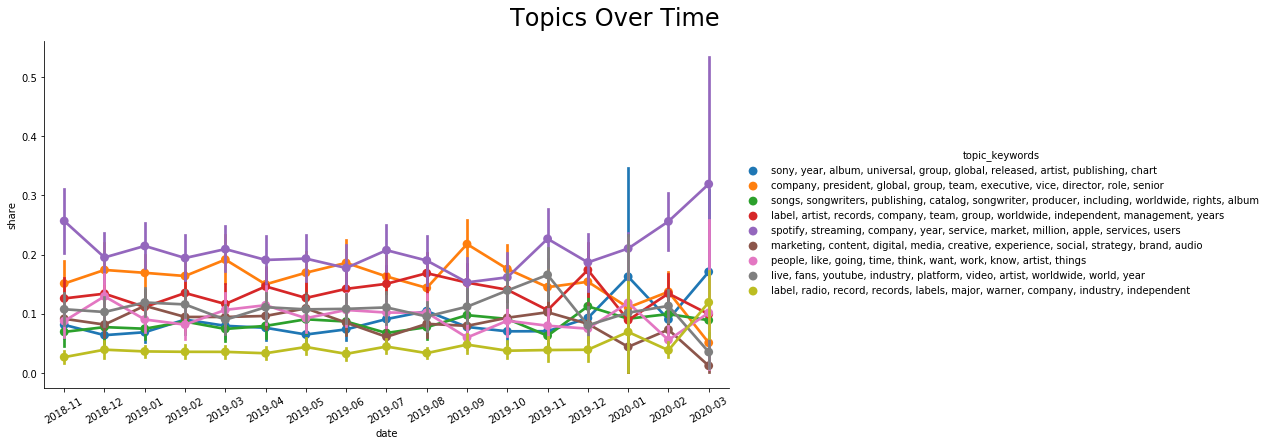

In [175]:
# http://jeriwieringa.com/2017/06/21/Calculating-and-Visualizing-Topic-Significance-over-Time-Part-1/
p = sns.factorplot(x="date", y='share', kind='point', hue_order=order, hue='topic_keywords',size=6, aspect=1.8, data=df)
p.fig.subplots_adjust(top=0.9)
p.fig.suptitle('Topics Over Time', fontsize=24)
p.set_xticklabels(rotation=30)